In [1]:
from matplotlib import pyplot as plt
import pandas as pd
from scipy.interpolate import splrep, BSpline
import numpy as np
from scipy import stats
import random
import math
from footprint_filter import filter_by_footprint
from voidiness import voidy_analysis

In [2]:
sdss_dr16 = pd.read_excel('exported_dataFrames/sdss_dr16_w_voidiness.xlsx')
four_lac = pd.read_excel('exported_dataFrames/4lac_w_voidiness.xlsx')

In [3]:
soft_xrays = pd.read_excel('exported_dataFrames/SBAT104_w_voidiness.xlsx')
hard_xrays = pd.read_excel('exported_dataFrames/ROMABZCAT_w_voidiness.xlsx')

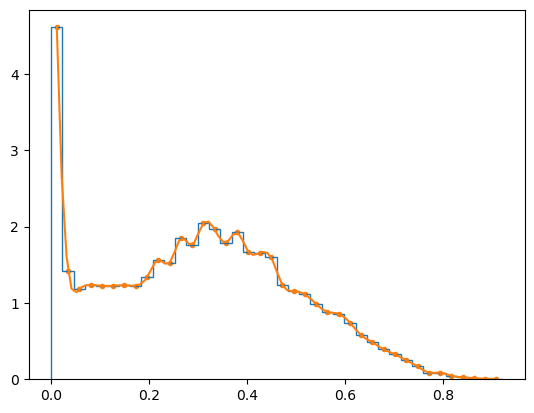

In [4]:
hist_data = plt.hist([sdss_dr16.Voidiness], 
                     bins = 40, 
                     density=True, 
                     stacked = False,
                     histtype='step')

bin_heights = hist_data[0]
# Calculate the centeres of the bins
bin_centers = []
for i in range(len(hist_data[1])-1):
    bin_centers.append((hist_data[1][i] + hist_data[1][i+1])/2)

plt.scatter(bin_centers, hist_data[0], marker='.')

# Interpolate between points
tck = splrep(bin_centers, bin_heights, s=0)
x = np.arange(min(bin_centers), max(bin_centers), 0.01)
plt.plot(x, BSpline(*tck)(x), '-', label=f's=0')


In [5]:
#
stats.ks_2samp(sdss_dr16.Voidiness, four_lac.Voidiness, method='exact')

KstestResult(statistic=0.11666147193662166, pvalue=0.0002478314729488103, statistic_location=0.3971037644216107, statistic_sign=1)

In [6]:
stats.ks_2samp(sdss_dr16.Voidiness, soft_xrays.Voidiness)

KstestResult(statistic=0.11244203601854846, pvalue=0.01755757846133372, statistic_location=0.1475855092339369, statistic_sign=-1)

In [7]:
stats.ks_2samp(sdss_dr16.Voidiness, hard_xrays.Voidiness)

KstestResult(statistic=0.06283992308223585, pvalue=0.05791296575557536, statistic_location=0.3831881698679801, statistic_sign=1)

In [8]:
stats.ks_2samp(sdss_dr16.Voidiness, four_lac.Voidiness[four_lac.TeVflag == 1], method='exact')

KstestResult(statistic=0.20933354901326431, pvalue=0.3011200919614163, statistic_location=0.2802377688239253, statistic_sign=1)

In [9]:
stats.ks_2samp(sdss_dr16.Voidiness, four_lac.Voidiness[np.isnan(four_lac.TeVflag)], method='exact')

KstestResult(statistic=0.12224430373896567, pvalue=0.00018639410216948646, statistic_location=0.3971037644216107, statistic_sign=1)

In [10]:
catalogs = ["Four_LAC","TEV_Sources", "NON_TEV_Sources", "SDSS_DR16", "ROMABZCAT", "SBAT104"]
stat_nums = ["Statistic", "pvalue"]
statistics = pd.DataFrame(np.nan, columns=catalogs, index  =catalogs)
data = [four_lac.Voidiness,
        four_lac.Voidiness[four_lac.TeVflag == 1],
        four_lac.Voidiness[np.isnan(four_lac.TeVflag)],
        sdss_dr16.Voidiness,
        hard_xrays.Voidiness,
        soft_xrays.Voidiness]

In [11]:
statistics = {}
for i in range(len(data)):
    temp = {}
    for j in range(i, len(data)): 
        temp[catalogs[j]] = stats.ks_2samp(data[i], data[j])
        # print(catalogs[i], catalogs[j], stats.ks_2samp(data[i], data[j]))
    statistics[catalogs[i]] = temp

In [12]:
stats_table = pd.DataFrame(statistics)

In [13]:
stats_table

,Four_LAC,TEV_Sources,NON_TEV_Sources,SDSS_DR16,ROMABZCAT,SBAT104
Four_LAC,"(0.0, 1.0)",NaN,NaN,NaN,NaN,NaN
TEV_Sources,"(0.15670731707317073, 0.6853632429122397)","(0.0, 1.0)",NaN,NaN,NaN,NaN
NON_TEV_Sources,"(0.010175799809946151, 1.0)","(0.16688311688311688, 0.61235328769397)","(0.0, 1.0)",NaN,NaN,NaN
SDSS_DR16,"(0.11666147193662169, 0.00024682521625024915)","(0.20933354901326434, 0.3010003051020268)","(0.12224430373896567, 0.0001863034328030673)","(0.0, 1.0)",NaN,NaN
ROMABZCAT,"(0.07845985201425049, 0.1827442706926773)","(0.19269662921348316, 0.4224222232442778)","(0.07430322486502262, 0.2510548851662401)","(0.06283992308223585, 0.05791296575557536)","(0.0, 1.0)",NaN
SBAT104,"(0.15853658536585366, 0.004626206199868378)","(0.24456521739130435, 0.1946353740374229)","(0.15422077922077923, 0.007253402335819552)","(0.11244203601854846, 0.01755757846133372)","(0.11595017098192477, 0.054738484496669036)","(0.0, 1.0)"


In [14]:
# Taken from custom_functions.py and modified for our purposes, 
# Since I've making new scripts for everything custom_functions is kind of depecrated
# and I didn't want to break it. 

def rand_long_and_lat(n, seeded=False, seed = 567307250717):
    """
    Generates number of longitude and latitude coordinates in degrees for entire pandasDF
    """
    if seeded:
        seed = seed # Using seed while debugging
    else:
        seed = None

    rng = np.random.default_rng(seed) 
    theta = np.arccos(1 - 2 * rng.uniform(0, 1, n)) * (180/math.pi) # COLAT
    b = 90 - theta
    l = rng.uniform(0, 360, n)
    return (l, b)
# Randomize

def gen_filtered_ra_deg(n):
    randRA, randDE = rand_long_and_lat(n)
    temp_cel = pd.DataFrame({'RAdeg': randRA, 'DEdeg': randDE})
    temp_cel = filter_by_footprint(temp_cel, 'exported_dataFrames/footprint_points_void_centers.xlsx')
    return temp_cel

In [63]:
# Monte Carlo of TEV
voids = pd.read_excel('exported_dataFrames/voids.xlsx')
master_TEV_Carlo = four_lac[four_lac.TeVflag == 1].copy()

run_n = 0
mc_voidiness = np.array([])
n_galxy = len(master_TEV_Carlo)


In [ ]:

while True:
    coords = gen_filtered_ra_deg(100000)
    coords_idx = coords.index.tolist()
    while len(coords_idx) > n_galxy:
        fresh_coords_idx = coords_idx[:n_galxy]
        coords_idx = coords_idx[n_galxy:]

        master_TEV_Carlo['RAdeg'] = coords.RAdeg[fresh_coords_idx].values
        master_TEV_Carlo['DEdeg'] = coords.DEdeg[fresh_coords_idx].values
        mc_voidiness = np.append(mc_voidiness, voidy_analysis(voids, master_TEV_Carlo).Voidiness.values)
        run_n += 1

(array([4.24653042, 1.0732989 , 1.21329441, 1.29106969, 1.25995958,
        1.44662025, 1.57106071, 1.22884946, 1.39995508, 1.4310652 ,
        1.44662025, 1.29106969, 1.25995958, 1.15107418, 0.79330788,
        0.38887641, 0.31110113, 0.2488809 , 0.06222023, 0.21777079]),
 array([0.        , 0.04285852, 0.08571704, 0.12857555, 0.17143407,
        0.21429259, 0.25715111, 0.30000963, 0.34286814, 0.38572666,
        0.42858518, 0.4714437 , 0.51430221, 0.55716073, 0.60001925,
        0.64287777, 0.68573629, 0.7285948 , 0.77145332, 0.81431184,
        0.85717036]),
 [<matplotlib.patches.Polygon at 0x14eaad6a0>])

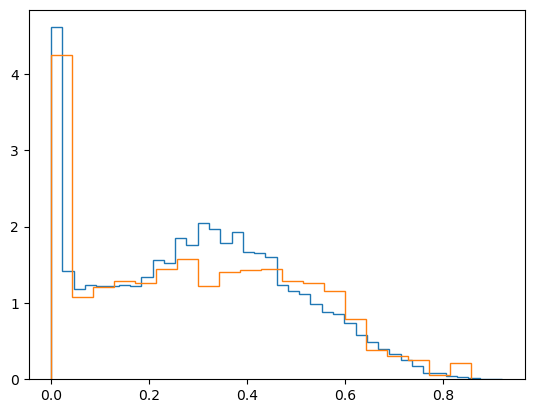

In [57]:
plt.hist([sdss_dr16.Voidiness], 
                     bins = 40, 
                     density=True, 
                     stacked = False,
                     histtype='step')

mc_names = ["Voidiness_" + str(i) for i in range(run_n-1)]

# for name in mc_names:
plt.hist([mc_voidiness], 
                    bins = 20, 
                    density=True, 
                    stacked = False,
                    histtype='step')

In [62]:
np.append(np.array([1, 2]),voidy_analysis(voids, master_TEV_Carlo).Voidiness.values)

array([1.        , 2.        , 0.68434381, 0.73119692, 0.38861842,
       0.14666994, 0.        , 0.20456421, 0.72622839, 0.22206291,
       0.3946882 , 0.61377575, 0.11342801, 0.25090098, 0.        ,
       0.40466285, 0.11151582, 0.32909954, 0.        , 0.51883436,
       0.15487415, 0.32512918])